In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
def create_summary_table(df):
    """
    Output summary statistics for each feature.
    """
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    
    cols = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
    summary = pd.concat([summary,pd.DataFrame(columns=cols)])
    for index, name in summary["Name"].iteritems():
        summary.at[index, cols] = df[name].describe().loc[cols].values
    
    summary = summary.astype({'Missing':int, "Uniques":int}) 
    return summary

In [3]:
df = pd.read_csv("../data/input/train.csv", index_col="company_id")

## Table of content

1. [About the dataset](#about-the-dataset)
2. [Class imbalance](#class-imbalance)
3. [Feature selection](#feature-selection)
4. [Data visualization](#data-visualization)

## About the dataset <a id="about-the-dataset"></a>

There is a total of 9792 companies in the dataset with 64 features. The target column is bankruptcy label which is encoded with 0 (no bankrupt) and 1 (bankrupt). 

Taking a quick look at the summary table, we can make a few observations:
1. Majority of the features are financial ratios, with 2 exceptions: **logarithm of total assets** (#28) and **working capital** (#54). 
2. All of the features are continuous (i.e no categorical features).
3. Most of the columns have low proportion of missing values, with the exception of **(current assets - inventories) / long-term liabilities** (#36), which has 4442 missing values. 
4. The features have very different scales so we might need to perform feature scaling as a pre-processing step (depending on which algorithm we use).    

In [4]:
summary_df = create_summary_table(df)
summary_df

Dataset Shape: (9792, 65)


,Name,dtypes,Missing,Uniques,mean,std,min,25%,50%,75%,max
0,net profit / total assets,float64,1,9313,0.04,0.36,-12.46,0.00,0.04,0.11,20.48
1,total liabilities / total assets,float64,1,9162,0.60,4.59,0.00,0.26,0.47,0.69,446.91
2,working capital / total assets,float64,1,9298,0.13,4.56,-445.91,0.02,0.20,0.41,22.77
3,current assets / short-term liabilities,float64,43,8703,8.14,290.65,-0.05,1.05,1.59,2.88,"27,146.00"
4,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,float64,21,9502,64.65,"14,759.39","-379,460.00",-51.22,-0.06,55.73,"1,034,100.00"
5,retained earnings / total assets,float64,1,5584,-0.06,6.81,-486.82,-0.00,0.00,0.07,322.20
6,EBIT / total assets,float64,1,9322,0.06,0.53,-12.46,0.00,0.05,0.13,38.62
7,book value of equity / total liabilities,float64,19,9233,19.88,698.70,-1.85,0.43,1.09,2.69,"53,209.00"
8,sales / total assets,float64,0,7773,1.88,17.67,-0.03,1.01,1.16,1.97,"1,704.80"
9,equity / total assets,float64,1,9208,0.39,4.59,-445.91,0.29,0.51,0.71,12.60


## Class imbalance <a id="class-imbalance"></a>

There is a heavy class imbalance issue in our dataset: only 5% of the companies bankrupt after 2 years.

If we just apply a naive model (predict no bankruptcy for all companies), we would have achieved a model with 95% accuracy. However, such a model would not be useful for a bank to decide which customer to lend to. A bank would be more interested in identifying companies which might bankrupt in the future and avoid lending to them, since the bank would have to write off the loan and incur losses if the customer eventually bankrupts. 

On the other hand, if our model predicts a customer will default but it does not (i.e a false positive), then the bank would miss out on this lending opportunity. However, I would argue that a **false negative still costs significantly more than a false positive.** 

Let's illustrate this with an example: Imagine the bank lends a £100 to a customer for 2 years and charges a 5% interest annually. Let's further assume that it is a non-amortizing loan so the payments on the principal are paid in a lump sum at the end of the 2-year period. If the customer cannot repays the loan, depending on the recovery rate, the bank might only be able to recoup, say, 50% of the principal. But if the bank refuses to lend to a customer which turns out to be a good customer, it would only lose out the potential interest income it could have generated: (2 years * 5% = 10%) of the principal.

*Note: This is just a simple example to illustrate the cost difference between false negative and false positive. In the real world, we would need to take into account the cost of capital, time value of money and the exact type of loan issued (secured vs unsecured, amortizing vs non-amortizing etc).*



In [5]:
target_frequency = df.bankruptcy_label.value_counts().rename("frequency")
target_proportion = df.bankruptcy_label.value_counts(normalize=True).rename("proportion")
pd.concat([target_frequency, target_proportion], axis=1)

,frequency,proportion
0,9277,0.95
1,515,0.05


### Metric

Given that recall will be weighted more important than precision, we will evaluate our model based on F-score:

\begin{equation}
F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{(\beta^2 \cdot precision) + recall}
\end{equation}

where β is chosen such that recall is considered β times as important as precision.

The highest possible value of an F-score is 1, indicating perfect precision and recall, and the lowest possible value is 0, if either the precision or the recall is zero.


## Feature selection <a id="feature-selection"></a>

Given that we have a large number of features to look at, instead of going through them one by one, we will apply some statistical tests and look at a subset of them based on the test result. 

In particular, given that we only have continuous features, we will apply **one-way ANOVA F-test** to each feature to determine whether there is a statistically significant difference between the feature means of bankrupt vs non-bankrupt companies. 

*Note: A Pearson correlation heatmap of continuous features with respect to the binary target will not be suitable in this case given that our target is not continuous. Technically, we could still calculate the correlation since our target is integer-coded (0 and 1) but we wouldn't have a natural interpretation of these correlation numbers. There is an alternative called the **point biserial correlation coefficient** which measures the relationship between a binary variable and a continuous variable, which you can read more about it [here](https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient).*

We only select those features which have p-value less than 1%.

In [6]:
from sklearn.feature_selection import f_classif

feature_cols = [col for col in df.columns if col != "bankruptcy_label"]
X = df[feature_cols]
y = df["bankruptcy_label"]

#fill missing values with zero
F, pval = f_classif(X.fillna(0), y)

pval_series = pd.Series(pval, index=X.columns)
pval_threshold = 0.01
top_features = pval_series[pval_series<pval_threshold].sort_values()
print(f"There are {len(top_features)} features with p-value less than {pval_threshold}: \n{top_features}")

There are 14 features with p-value less than 0.01: 
net profit / total assets                                                  0.00
profit on sales / total assets                                             0.00
logarithm of total assets                                                  0.00
(gross profit + interest) / total assets                                   0.00
EBIT / total assets                                                        0.00
(gross profit + extraordinary items + financial expenses) / total assets   0.00
profit on operating activities / total assets                              0.00
(sales - cost of products sold) / sales                                    0.00
profit on sales / sales                                                    0.00
gross profit / total assets                                                0.00
gross profit / short-term liabilities                                      0.00
(net profit + depreciation) / total liabilities                     

### Multicollinearity


One thing to note here is that we are using univariate feature selection method so it doesn't take into account the interaction between features. Hence, we might select features which are highly correlated with one another. If we want to drop some highly correlated features, we might consider using LASSO method for feature selection.

We also observe that 13 of the 14 selected features have *profit* as the numerator. Using our domain knowledge of financial accounting, we know that there is only a slight variation between these different profit figures (gross profit, net profit, EBIT, EBITDA etc) so we can broadly group them into three categories:
1. **Return on asset** (ratio of profit to assets)
2. **Solvency ratio** (ratio of profit to liabilities)
3. **Profit margin** (ratio of profit to sales)

Therefore, we expect to see a high positive correlations within these 3 groups of features.    

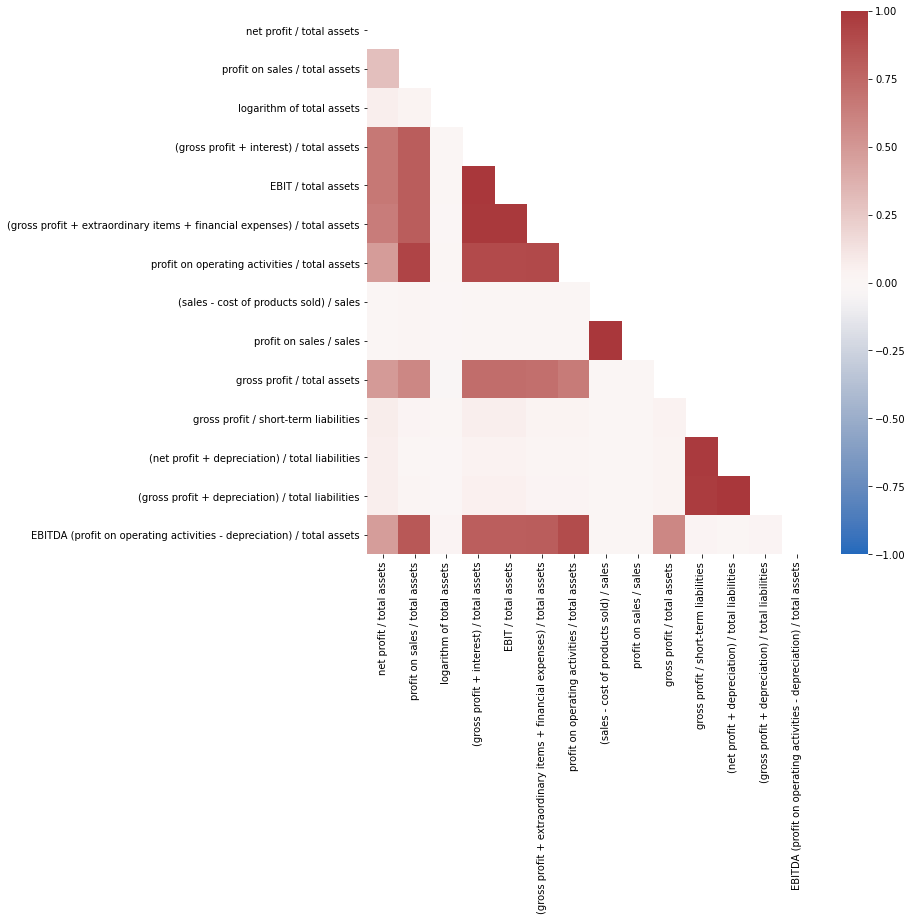

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
corr_df = X[top_features.index].corr(method="pearson")
mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.heatmap(corr_df, cmap="vlag", vmin=-1, vmax=1, mask=mask, ax=ax)

## Data visualization <a id="data-visualization"></a>

Let's look at the boxplot of selected features for bankrupt vs non-bankrupt companies. 

Again, using our domain knowledge, we would expect to see *lower return on asset*, *lower solvency ratio* and *lower profit margin* for bankrupt companies. 

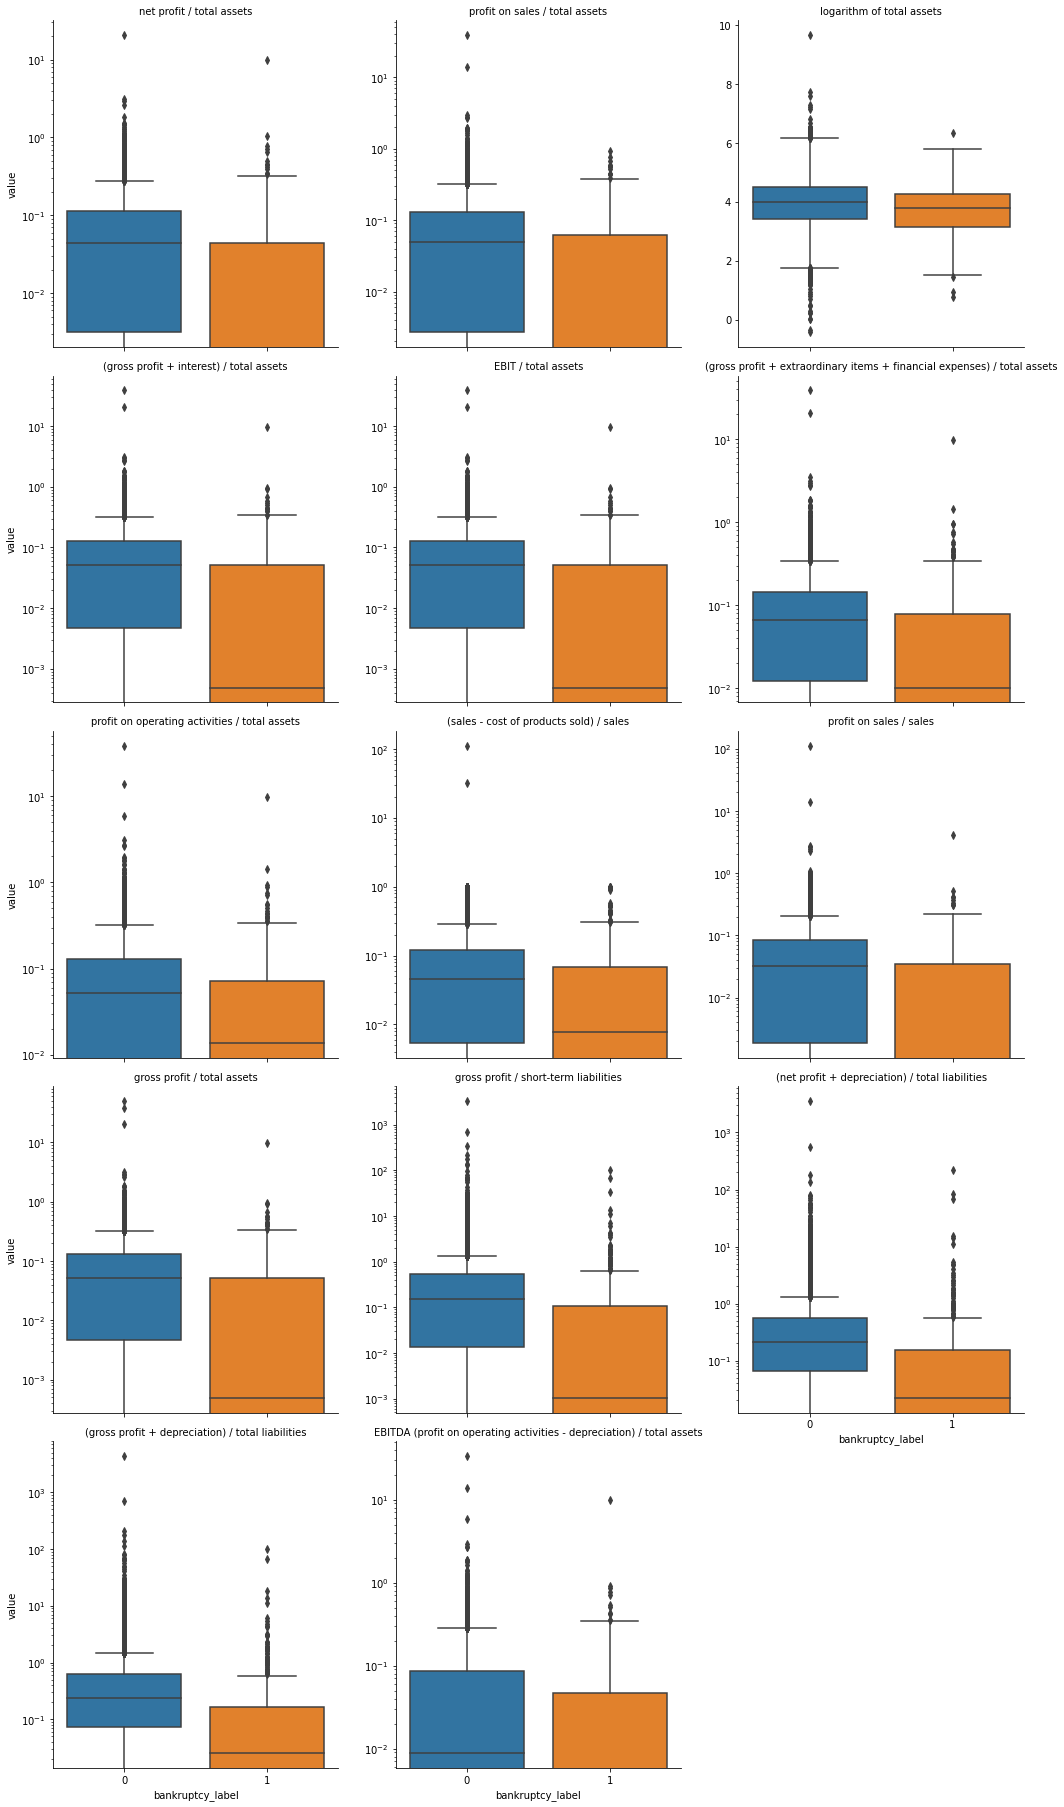

In [8]:
# melt the df to use seaborn function
cols = top_features.index.to_list() + ["bankruptcy_label"]
melted_df = df[cols].reset_index().melt(id_vars=["company_id", "bankruptcy_label"])

g = sns.catplot(data=melted_df, x="bankruptcy_label", y="value", col="variable", kind="box", col_wrap=3, sharey=False)
g.set_titles(col_template="{col_name}")

# plot in logarithmic scale as there are a few companies with extremely large values 
for ax in g.axes.flatten():
    if ax.get_title() != "logarithm of total assets":
        ax.set_yscale('log')

## Outliers

You might notice that we use logarithmic scale to show the boxplots in the figure above. This is because the dataset contains some very large outliers.  

In the real world, we would need to investigate these outliers because depending on how this data is collected, there could be a number of reasons why we have these outliers:
1. These companies actually do not exist. They were created artificially as "test" data but were accidentally left in the dataset.   
2. The financial information was scraped from the companies annual report by an algorithm which does not have a perfect accuracy. 
3. Human errors when collecting the data.   
4. The data collection process is robust and these companies do exist with these large values.  

This is why it's always important to perform exploratory data analysis and not just blindly accept the dataset as correct. As a data scientist, you would also need to understand the context of the problem and go as far as investigating the source of the dataset.

For the purpose of this notebook, we will assume that after speaking with the data engineers, we can confirm that these outliers are valid observations. Therefore, we will include them in training the model. 

## Next step

Our next step is to use these features to train our model and we will evaluate the model using F-beta score. We will continue this in the next notebook.